# This notebook implements Method-2 using Vision Language Model Img-Text generation to create Knowledge Graphs.

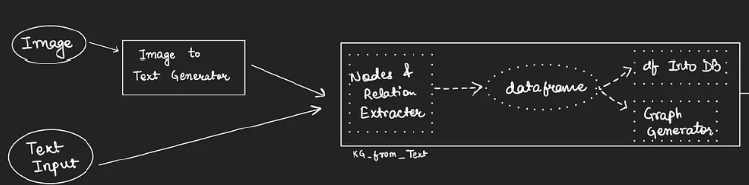

In [1]:
!pip install -q -U transformers==4.37.2
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0
!pip install -q neo4j networkx plotly graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 18.9 MB/s eta 0:00:00


In [2]:
import torch

device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

## Loading 4bit quantised LLava model --- > https://llava-vl.github.io/

In [4]:
from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

# To use, pass any image path or image link to load_image

In [5]:
import requests
from PIL import Image

def load_image(image_file):
    if image_file.startswith("http://") or image_file.startswith("https://"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


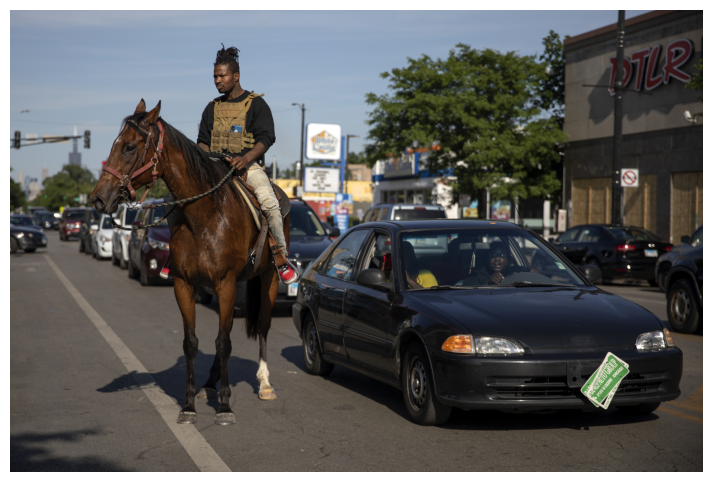

In [70]:
image = load_image("/content/action_genome_dataset1.jpg")
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

## Generation of VLM's text description of image

In [28]:
max_new_tokens = 200
prompt = "USER: <image>\nDescribe in detail the objects and what is hapenning in the image to me. The description should be of 200 words. \nASSISTANT:"
result_list=[]

for i in range(1):
  outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

  response_text = outputs[0]['generated_text']
  assistant_prefix = "ASSISTANT:"
  response = response_text.split(assistant_prefix, 1)[-1].strip() if assistant_prefix in response_text else response_text
    # Split the text by \n and .
  segments = response.split('.')
  lines = [segment.split('\n') for segment in segments]

  # Flatten the list of lists into a single list
  print(lines)

  for texts in lines:
    if texts[0] !='':
     sentence=texts[0]
     result_list.append(sentence)

  #response = [item.strip() for sublist in lines for item in sublist if item.strip()]

[['The image depicts a man riding a horse down a busy street'], [' The horse is positioned in the middle of the street, and the man is skillfully guiding it through the traffic'], [' There are several cars and a truck visible in the scene, with some cars being closer to the horse and others further away'], ['', '', 'Apart from the man on the horse, there are two other people in the image, one standing near the right edge of the frame and the other person located towards the right side of the scene'], [' The street appears to be bustling with activity, as the man on the horse navigates through the traffic'], ['']]


In [36]:
result_text=''

for i in result_list:
  result_text= result_text+ i

result_list=[]
result_list.append(result_text)

#Convert the result to dataframe

In [37]:
import pandas as pd
import numpy as np

df=pd.DataFrame({"text":result_list})
df

,text
0,The image depicts a man riding a horse down a ...


## Once we get the image description we need to extract triplets. REBEL model is used for extracting triplets of head: relation :tail in image.


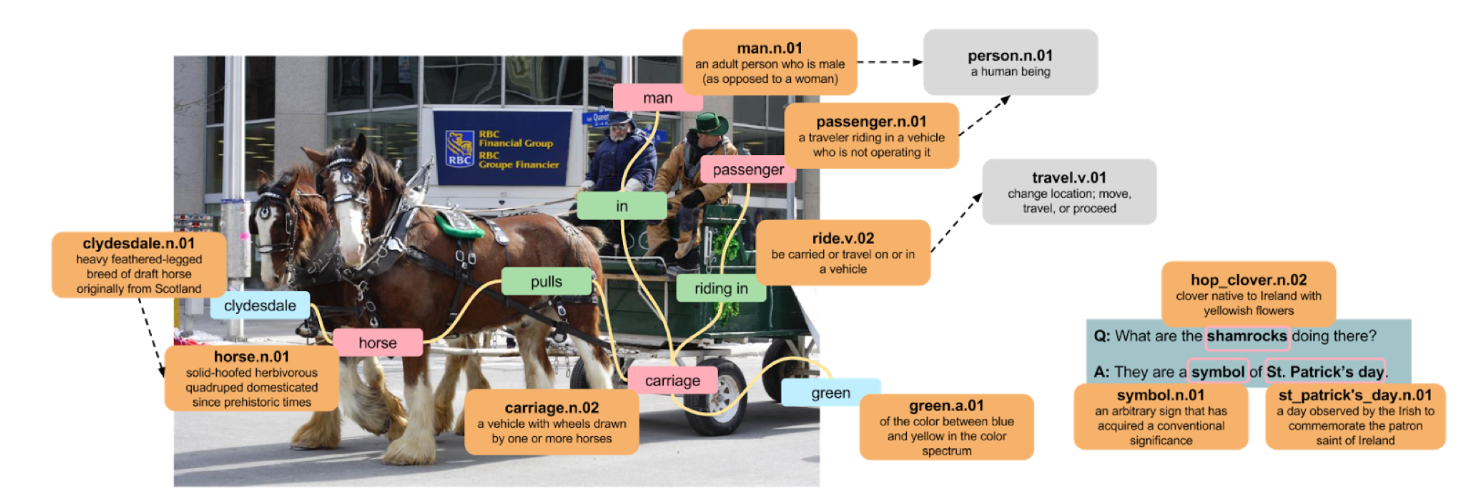

## Loading REBEL model for relation extraction

In [10]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
from tqdm import tqdm
import torch
#from pyvis.network import Network

# Loading REBEL-Large

In [11]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")
gen_kwargs = {
    "max_length": 512,
    "length_penalty": 0,
    "num_beams": 3,
    "num_return_sequences": 3,
}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [20]:
from transformers import pipeline

triplet_extractor = pipeline('text2text-generation',
        model='Babelscape/rebel-large',
        tokenizer='Babelscape/rebel-large',
        device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


#Relation extraction Triplets using REBEL-Large

In [54]:
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets


# Extraction of Triplets

In [55]:
df['text']

,text
0,The image depicts a man riding a horse down a ...


In [56]:
triplet_list=[]
for i in range(len(df)):
  text=df['text'][i]
  model_inputs= tokenizer(text, max_length= 256, padding=True, truncation=True, return_tensors = 'pt')

  generated_tokens= model.generate(
      model_inputs["input_ids"].to(model.device),
      attention_mask=model_inputs["attention_mask"].to(model.device),
      **gen_kwargs,
  )

  decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)
  # Extract triplets
  for _, sentence in enumerate(decoded_preds):
      triplet_list.append(extract_triplets(sentence))

triplet_list

[[{'head': 'horse', 'type': 'used by', 'tail': 'man'}],
 [{'head': 'horse', 'type': 'use', 'tail': 'rider'}],
 [{'head': 'man riding a horse', 'type': 'uses', 'tail': 'horse'}]]

In [57]:
df['text'][0]

'The image depicts a man riding a horse down a busy street The horse is positioned in the middle of the street, and the man is skillfully guiding it through the traffic There are several cars and a truck visible in the scene, with some cars being closer to the horse and others further away The street appears to be bustling with activity, as the man on the horse navigates through the traffic'

In [58]:
triplet_list = [item for sublist in triplet_list for item in sublist]

In [59]:
df_rebel=pd.DataFrame({'triplet':triplet_list})

In [60]:
df_rebel

,triplet
0,"{'head': 'horse', 'type': 'used by', 'tail': '..."
1,"{'head': 'horse', 'type': 'use', 'tail': 'rider'}"
2,"{'head': 'man riding a horse', 'type': 'uses',..."


In [61]:
triplets=df_rebel['triplet'].to_list()

# After Triplet, using NetworkX

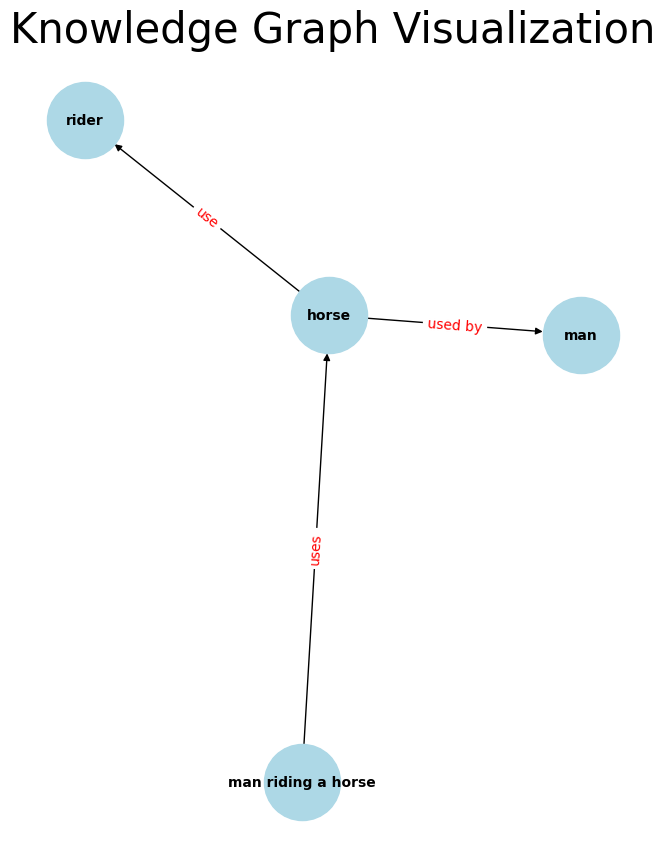

In [69]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()

# Add edges to the graph
for row in triplets:
    if isinstance(row, dict):  # Ensure the item is a dictionary
        G.add_edge(row['head'], row['tail'], label=row['type'])
# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(6, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')

plt.title('Knowledge Graph Visualization',fontsize=30)
plt.show()

## Conclusion

---



## Although the VLM Llava and REBEL generate the Knowledge graph but it misses several aspects like busy street, car and others which could have made the knowledge base more contxtual aware of the image dataset.

## The problem?

- Due to short and less length description of the image, the REBEL model fails to get insights to create triplets.